<a href="https://colab.research.google.com/github/abyaadrafid/Deep-Reinforcement-Learning/blob/master/Policy%20Gradients/Value_Actor_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Value Actor Critic

Value actor critics are known as the basic version of the actor critic methods. It tries to learn both the value and the policy and incorporates the best of both worlds. It approximates the state value for the agent and updates the policy with the value. And in turn, uses the updated policy to better approximate the state values. 

In the policy gradient notebook, we have used the discounted returns from actions along with the log probability of the policy to learn our target policy. As it happens, using baselines for expected discounted returns yield better results as the policy updates become smaller; reducing chance of the policy degrading arbitrarily. This is the basis of the Actor Critic algorithms. 

## Models
There are two models in actor critic methods, which optionally share parameters:

  1. The critic : Updates value function parameters. The value function can be action value or state value depending on the implementation specification. In this case we are going to use the state value function.

  2. The actor : Updates policy parameters as suggested by the critic.

## Formation
If we consider V(s) as our value function and G our discounted returns, instead of using G directly in policy gradient, we can use this :

`delta = G - V(s)`

We use this `delta` quantity to apply gradient ascent on our actor policy, and minimize the squared `delta` for our value function.
We can also use HuberLoss on G and V(s) and minimize it for our critic. 

In [ ]:
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines[mpi]==2.10.0 box2d box2d-kengz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libopenmpi-dev is already the newest version (2.1.1-8).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import numpy as np
import pandas as pd
import gym
import matplotlib.pyplot as plt
from torch.distributions import Categorical
%matplotlib inline

plt.style.use('seaborn')

## Gym environment

As usual, we will be using the LunarLander environment.

In [ ]:
env = gym.make('LunarLander-v2')
env.seed(0)
print(env.action_space)
print(env.observation_space)

Discrete(4)
Box(8,)


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Template for Deep Network

In this particular implementation I have decided to share some parameters between the actor and the critic. There is no particular reason behind it, the algorithm works even if we use separate parameters.

The model has a shared `stem` consisting of two linear layers and relu activations. Then there are two `head`s for each outputs: 

  1. The actor returns the softmaxed probability distribution of the actions according to the policy, given the state.
  2. The critic returns a single number, which is the expected value of the given state. 

In [ ]:
class ActorCritic(nn.Module):
  def __init__(self, state_size, action_size, fc1_size = 128, fc2_size = 256):
    super(ActorCritic, self).__init__()

    self.stem = nn.Sequential(
        nn.Linear(state_size, fc1_size),
        nn.ReLU(),
        nn.Linear(fc1_size, fc2_size),
        nn.ReLU()
    )

    self.actor = nn.Sequential(
        self.stem,
        nn.Linear(fc2_size, action_size),
        nn.Softmax()
    )
    
    self.critic = nn.Sequential(
        self.stem,
        nn.Linear(fc2_size, 1),
    )

  def forward(self, x):

    value = self.critic(x)
    probabilities = self.actor(x)
    dist = Categorical(probabilities)

    return dist, value

## Monte carlo variants
There are some implementation of this algorithm as monte carlo method as well. This implementation will not follow that variant.

To do it, all we need to do is only call learn only when an episode is finished. A simple check on the done flag for every time step will do the trick. We will have to store the rewards, values and log probs upto that point. These quantities will then be used to update the policy and the value function. 

In [ ]:
class ValueACAgent():
  def __init__(self, lr, state_size, action_size, fc1_size = 128, fc2_size = 256, gamma= 0.99):
    self.gamma = gamma
    self.actor_critic = ActorCritic(state_size, action_size, fc1_size, fc2_size).to(device)
    self.optimizer = optim.Adam(self.actor_critic.parameters(), lr)
    self.log_probs = None

  def choose_action(self, state):
    action_probs, _ = self.actor_critic.forward(torch.tensor(state).to(device))
    action = action_probs.sample()
    self.log_probs = action_probs.log_prob(action)
    
    return action.item()

  def learn(self, state, reward, done):
    _, value = self.actor_critic.forward(torch.tensor(state).to(device))
    
    delta = reward - value

    actor_loss = -self.log_probs*delta
    critic_loss = (delta**2)

    loss = actor_loss + 0.5*critic_loss

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

In [ ]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print('State size: {}, action size: {}'.format(state_size, action_size))

State size: 8, action size: 4


In [ ]:
agent = ValueACAgent(1e-5, state_size=state_size, action_size=action_size)

N_EPISODES = 3000
MAX_STEPS = 1000
gamma = 0.99
PRINT_EVERY = 50
ENV_SOLVED = 200

## N step variants

In This implementation the agent learns in every timestep. Effectively agent.learn should be called after every n steps. Subsequent states, rewards and done flags must be stored.

In [ ]:
def train(agent):
  score_history = []
  print_score = []
  for i in range(N_EPISODES):
    state = env.reset()
    episode_score = 0
    done = False

    while not done:
      action = agent.choose_action(state)
      next_state, reward, done, info = env.step(action)
      agent.learn(state, reward, done)
      
      state = next_state
      episode_score += reward

    score_history.append(episode_score)
    print_score.append(episode_score)
    if i % PRINT_EVERY == 0 :
      print('\r Progress {}/{}, average score:{:.2f}'.format(i, N_EPISODES, np.mean(print_score)), end="")
      print_score = []
    if episode_score == ENV_SOLVED :
      print('The Environment is solved')
  return score_history

In [ ]:
def plot(score, string):
  plt.figure(figsize=(10,6))
  plt.plot(score)
  plt.plot(pd.Series(score).rolling(100).mean())
  plt.title('%s Training,'%string)
  plt.xlabel('# of episodes')
  plt.ylabel('score')
  plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 Progress 2950/3000, average score:-80.20

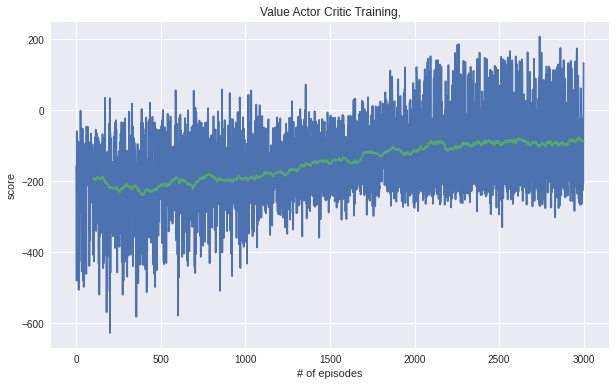

In [ ]:
score = train(agent)
plot(score, 'Value Actor Critic')

##### As we can see, the agent isn't actually that great. But slowly and surely it shows increase in performance on average. The Value actor critic can be quite unstable while training, as seen from the huge fluctuations of reward between episodes. It takes more episodes than all other methods we've covered so far. It does not solve the problem within our episode limit, but it is very close. 